In [3]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Parameters
SPEED_THRESHOLD = 4  # m/s
MIN_STOP_DURATION = 1.0  # seconds
DIST_THRESH = 1
EXPORT_INTERVAL = 0.16  # seconds
PED_BOX = (0.3, 0.3)
MOTO_BOX = (1.87, 0.64)

# ----------------------------------
# Helpers
# ----------------------------------

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out stopped vehicles longer than threshold"""
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    return df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))].drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

def get_rotated_corners(x, y, heading, length, width):
    """Return coordinates of rotated bounding box corners"""
    half_l, half_w = length / 2, width / 2
    corners = np.array([
        [ half_l,  half_w],
        [ half_l, -half_w],
        [-half_l, -half_w],
        [-half_l,  half_w]
    ])
    rad = np.radians(heading)
    rot = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])
    return (corners @ rot.T) + np.array([x, y])

def get_closest_corners(row):
    """Get direction vector and min distance between closest corners"""
    ped_corners = get_rotated_corners(row['x_smooth_ped'], row['y_smooth_ped'], row['HA_ped'], *PED_BOX)
    moto_corners = get_rotated_corners(row['x_smooth_moto'], row['y_smooth_moto'], row['HA_moto'], *MOTO_BOX)
    dists = cdist(ped_corners, moto_corners)
    idx = np.unravel_index(np.argmin(dists), dists.shape)
    min_dist = dists[idx]
    direction_vec = moto_corners[idx[1]] - ped_corners[idx[0]]
    return min_dist, direction_vec

def calculate_attc(row):
    """Compute ATTC using projection of relative motion on direction vector"""
    min_dist, direction_vec = get_closest_corners(row)
    vel_ped_x = row['vx_smooth_ped']
    vel_ped_y = row['vy_smooth_ped']
    vel_moto_x = row['vx_smooth_moto']
    vel_moto_y = row['vy_smooth_moto']
    acc_ped_x = row['ax_ped']
    acc_ped_y = row['ay_ped']
    acc_moto_x = row['ax_moto']
    acc_moto_y = row['ay_moto']
    closing_rate = np.sqrt((vel_ped_x -(vel_moto_x+acc_moto_x*0.16))**2+(vel_ped_y -(vel_ped_y+acc_ped_y*0.16))**2)
    return min_dist / closing_rate if closing_rate > 0 else np.inf

# ----------------------------------
# Load Data
# ----------------------------------

df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_moto = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv")
df_moto['speed'] = np.sqrt(df_moto['vx_smooth']**2 + df_moto['vy_smooth']**2)

# Filter stopped vehicles
print(f"Original motorcycle count: {len(df_moto)}")
df_moto = filter_stopped_vehicles(df_moto, speed_col='speed')
print(f"Filtered motorcycle count: {len(df_moto)}")

# Calculate yaw rates
for df in [df_ped, df_moto]:
    df['yaw_rate'] = df.groupby('Track ID').apply(
        lambda x: x['HA'].diff() / x['TimeStamp'].diff()
    ).reset_index(level=0, drop=True)

# Round timestamps
df_ped['Time_rounded'] = (df_ped['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL
df_moto['Time_rounded'] = (df_moto['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL


Original motorcycle count: 307259
Filtered motorcycle count: 77484


C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_3660\3456107647.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(
C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_3660\3456107647.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(


In [4]:

# ----------------------------------
# Merge and Process
# ----------------------------------

merged = pd.merge(
    df_ped, 
    df_moto, 
    on='Time_rounded', 
    suffixes=('_ped', '_moto')
)

merged['Center_dist'] = np.hypot(
    merged['x_smooth_ped'] - merged['x_smooth_moto'],
    merged['y_smooth_ped'] - merged['y_smooth_moto']
)

# Filter by center threshold
results = merged[merged['Center_dist'] <= DIST_THRESH].copy()

# Calculate ATTC using corrected method
results['ATTC'] = results.apply(calculate_attc, axis=1)
results[['mindis', 'direction_vec']] = results.apply(
    lambda row: pd.Series(get_closest_corners(row)),
    axis=1
)
# Output
output = results[['Track ID_ped', 'Track ID_moto', 'TimeStamp_ped', 'ATTC']].rename(columns={
    'Track ID_ped': 'Ped_ID',
    'Track ID_moto': 'Moto_ID',
    'TimeStamp_ped': 'TimeStamp'
})
print(output)
len(results[(results['ATTC']<1) & (results['mindis']<1)][['Track ID_ped', 'Track ID_moto']].drop_duplicates())

        Ped_ID  Moto_ID  TimeStamp       ATTC
1843       282      302     106.84   0.221190
1854       282      302     107.16   3.074590
1855       282      302     107.16   1.953923
5202       381      407     130.16   0.614309
5203       381      407     130.32   0.750066
...        ...      ...        ...        ...
368384   15693    15756    5396.60   0.563124
368389   15693    15756    5396.76   0.790017
368396   15693    15756    5396.92   1.531201
368401   15693    15756    5397.08  17.986807
368407   15693    15756    5397.24   1.632980

[653 rows x 4 columns]


140

In [5]:
results[(results['mindis']<1)][['ATTC']].max()

ATTC    25973.307308
dtype: float64

In [6]:
results['ATTC'].max()

np.float64(inf)

(array([127.,  85.,  75.,  46.,  36.,  23.,  25.,  14.,  11.,  12.,  17.,
          9.,  10.,   7.,   5.,  12.,   0.,   5.,   4.,   3.,   1.,   4.,
          3.,   3.,   1.,   0.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,
          2.,   1.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   1.]),
 array([0.01101247, 0.21055954, 0.41010661, 0.60965368, 0.80920075,
        1.00874782, 1.20829489, 1.40784196, 1.60738903, 1.8069361 ,
        2.00648317, 2.20603024, 2.40557731, 2.60512438, 2.80467145,
        3.00421852, 3.20376559, 3.40331266, 3.60285974, 3.80240681,
        4.00195388, 4.20150095, 4.40104802, 4.60059509, 4.80014216,
        4.99968923, 5.1992363 , 5.39878337, 5.59833044, 5.79787751,
        5.99742458, 6.19697165, 6.39651872, 6.59606579, 6.79561286,
        6.99515993, 7.194707  , 7.39425407, 7.59380114, 7.79334821,
        7.99289528, 8.19244235, 8.39198942, 8.59153649, 8.79108356,
        8.99063063, 9.1901777 , 9.38972477, 9.

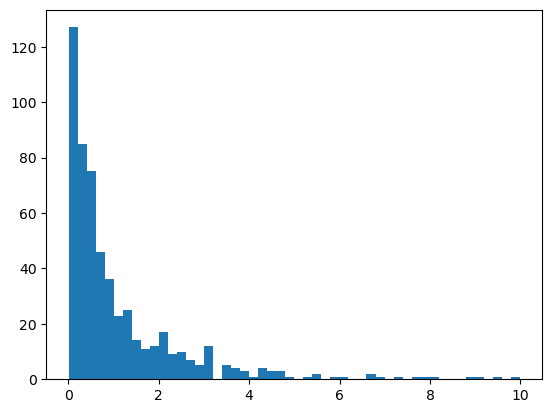

In [13]:
import matplotlib.pyplot as plt

plt.hist(results[(results['mindis']<1)& (results['ATTC'] < 10)]['ATTC'], bins=50)

     Track ID_ped  Track ID_moto    mindis      ATTC
0             282            302  0.264678  0.221190
1             381            407  0.455059  0.481677
2             391            390  0.609514  0.618801
3             417            433  0.442770  0.190047
4            1151           1157  0.168981  0.097652
..            ...            ...       ...       ...
151         15522          15531  0.409644  0.137368
152         15585          15719  0.131350  0.017511
153         15602          15624  0.403486  0.262244
154         15693          15716  0.259293  0.430699
155         15693          15756  0.640313  0.494222

[156 rows x 4 columns]


(array([43., 29., 17., 12.,  9., 12.,  5.,  6.,  4.,  2.,  1.,  1.,  2.,
         1.,  2.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01101247, 0.09698098, 0.18294949, 0.268918  , 0.35488651,
        0.44085502, 0.52682353, 0.61279204, 0.69876054, 0.78472905,
        0.87069756, 0.95666607, 1.04263458, 1.12860309, 1.2145716 ,
        1.30054011, 1.38650861, 1.47247712, 1.55844563, 1.64441414,
        1.73038265, 1.81635116, 1.90231967, 1.98828818, 2.07425668,
        2.16022519, 2.2461937 , 2.33216221, 2.41813072, 2.50409923,
        2.59006774, 2.67603625, 2.76200475, 2.84797326, 2.93394177,
        3.01991028, 3.10587879, 3.1918473 , 3.27781581, 3.36378432,
        3.44975282, 3.53572133, 3.62168984, 3.70765835, 3.79362686,
        3.87959537, 3.96556388, 4.05153239, 4.13750089, 4.2234694 ,
        4.30943791]),
 <BarContainer

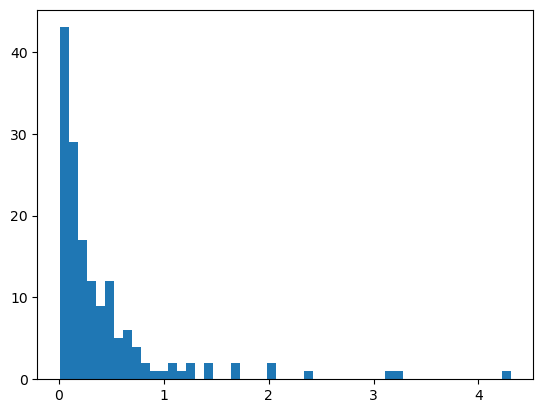

In [23]:
# Step 1: Filter for mindis < 1
filtered = results[results['mindis'] < 1]

# Step 2: Group by Track ID pair and get row with min ATTC
final = filtered.loc[filtered.groupby(['Track ID_ped', 'Track ID_moto'])['ATTC'].idxmin()]

# Step 3: Keep only desired columns
final = final[['Track ID_ped', 'Track ID_moto', 'mindis', 'ATTC']].reset_index(drop=True)
print(final)
plt.hist(final['ATTC'], bins=50)


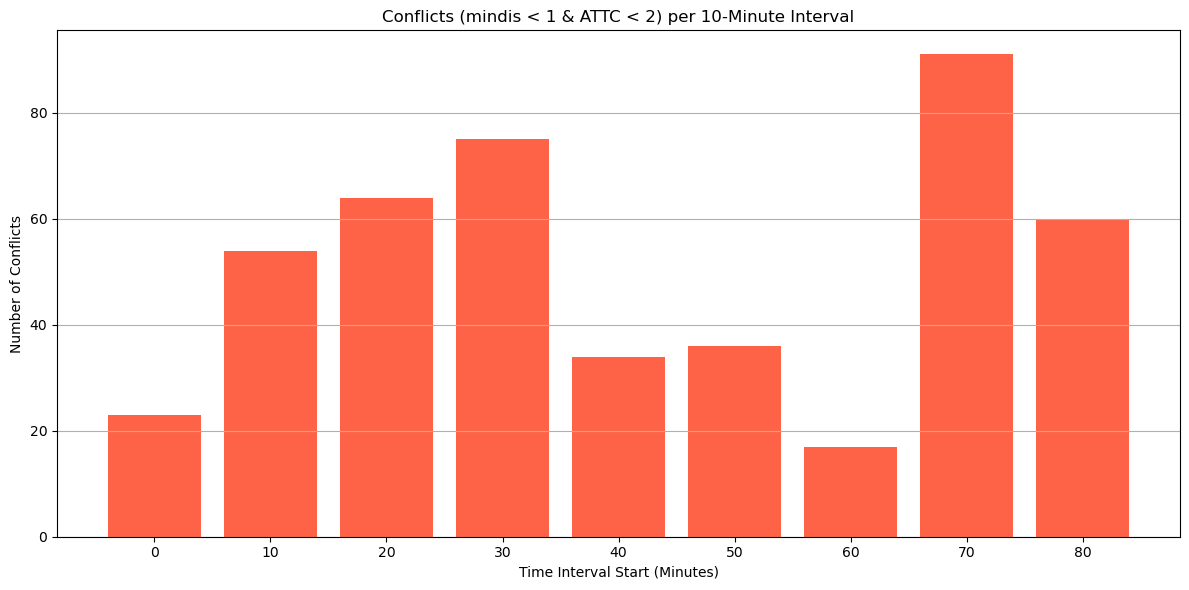

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create 10-minute bins from TimeStamp_ped (assuming it's in seconds)
results['time_bin'] = (results['TimeStamp_ped'] // 600) * 10  # 600 sec = 10 min

# Step 2: Filter for conflict cases
conflicts = results[(results['mindis'] < 1) & (results['ATTC'] < 2)]

# Step 3: Count number of conflicts per 10-minute bin
conflict_counts = conflicts.groupby('time_bin').size().reset_index(name='conflict_count')

# Step 4: Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(conflict_counts['time_bin'], conflict_counts['conflict_count'], width=8, align='center', color='tomato')
plt.xlabel('Time Interval Start (Minutes)')
plt.ylabel('Number of Conflicts')
plt.title('Conflicts (mindis < 1 & ATTC < 2) per 10-Minute Interval')
plt.xticks(conflict_counts['time_bin'])  # Show each 10-minute mark
plt.grid(axis='y')
plt.tight_layout()
plt.show()
